In [2]:
#Load the libraries
import numpy as np
import pandas as pd
import datetime as dt
from fbprophet import Prophet
from tqdm.notebook import tqdm
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
url4 = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
url5 = 'https://raw.githubusercontent.com/marmaluffalo/bigdataproject/master/covid-stringency-index.csv'

In [4]:
owid = pd.read_csv(url4)
owid['date'] = pd.to_datetime(owid['date'])
owid.rename(columns={'location':'CountryName', 'iso_code':'CountryCode', 'date':'Date'}, inplace=True)
owid.head()

,CountryCode,continent,CountryName,Date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN


In [5]:
## lag death data by 42 days
lagdeath = owid[['CountryName', 'Date', 'new_deaths_per_million']]
#time_change = dt.timedelta(days=8)
lagdeath['LagDate'] = lagdeath['Date'] + pd.DateOffset(42)
lagdeath = lagdeath.drop(columns = ['Date'])
lagdeath.rename(columns={'LagDate':'Date','new_deaths_per_million':'LagDeath'}, inplace=True)
lagdeath.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CountryName,LagDeath,Date
0,Afghanistan,NaN,2020-04-06
1,Afghanistan,NaN,2020-04-07
2,Afghanistan,NaN,2020-04-08
3,Afghanistan,NaN,2020-04-09
4,Afghanistan,NaN,2020-04-10


In [6]:
death = owid[['CountryName', 'Date', 'new_deaths_per_million', 'people_vaccinated_per_hundred']]
death.rename(columns={'new_deaths_per_million':'Death', 'people_vaccinated_per_hundred':'Vax'}, inplace=True)
death.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CountryName,Date,Death,Vax
0,Afghanistan,2020-02-24,NaN,NaN
1,Afghanistan,2020-02-25,NaN,NaN
2,Afghanistan,2020-02-26,NaN,NaN
3,Afghanistan,2020-02-27,NaN,NaN
4,Afghanistan,2020-02-28,NaN,NaN


In [7]:
## import stringency data
stringency = pd.read_csv(url5)
stringency['Day'] = pd.to_datetime(stringency['Day'])
stringency.rename(columns={'Entity':'CountryName', 'Code':'CountryCode', 'Day':'Date'}, inplace=True)
stringency.head()

,CountryName,CountryCode,Date,stringency_index
0,Afghanistan,AFG,2020-01-21,0.0
1,Afghanistan,AFG,2020-01-22,0.0
2,Afghanistan,AFG,2020-01-23,0.0
3,Afghanistan,AFG,2020-01-24,0.0
4,Afghanistan,AFG,2020-01-25,0.0


In [36]:
## merge stringency and lagged deaths
data = stringency.merge(right=lagdeath, how = 'left', on = ['CountryName', 'Date'], copy=False)
data = data.merge(right=death, how = 'left', on = ['CountryName', 'Date'], copy=False)
data = data[['CountryName', 'Date', 'stringency_index', 'Vax', 'Death', 'LagDeath']]
#data = data.dropna(axis='rows')
data = data.fillna(0)
data.columns = ['CountryName', 'ds', 'stringency', 'vax', 'death', 'lagdeath']
data['ds'] = pd.to_datetime(data['ds'], errors='coerce')

## daily data is too volatile
## aggregate by week
data = data.groupby(['CountryName', pd.Grouper(key='ds', freq='W-MON')]).agg({'stringency':'mean', 'vax':'mean',
                                                                              'death':'mean', 'lagdeath':'mean'}).reset_index()
data = data.groupby('CountryName').filter(lambda x: len(x) > 10)
## some countries don't have recent data
data = data[data['ds'] < '2021-09-18']

data['lagds'] = data['ds'] + pd.DateOffset(42)
data.sample(6)

,CountryName,ds,stringency,vax,death,lagdeath,lagds
3559,Cyprus,2020-06-29,55.022857,0.000000,0.000000,0.160857,2020-08-10
11989,Serbia,2020-06-15,27.780000,0.000000,0.105000,0.735000,2020-07-27
10721,Panama,2020-08-10,80.560000,0.000000,5.445000,3.228000,2020-09-21
11580,Russia,2020-09-21,38.890000,0.000000,0.829286,0.773571,2020-11-02
8888,Mali,2021-05-24,44.440000,0.050000,0.020571,0.144000,2021-07-05
3863,Denmark,2021-05-31,55.560000,35.288571,0.172000,0.393143,2021-07-12


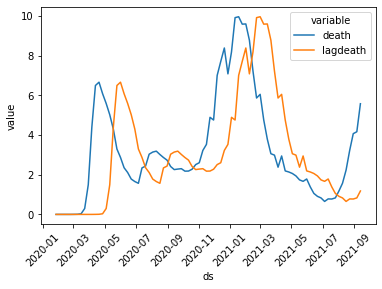

In [9]:
usa = data[data['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['death', 'lagdeath'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa)
plt.xticks(rotation=45)
plt.show(g)

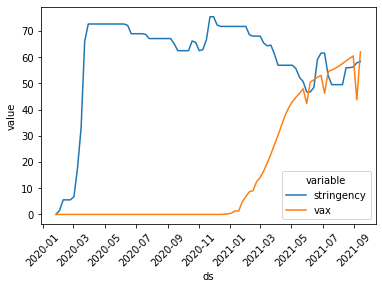

In [40]:
usa = data[data['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['stringency', 'vax'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa)
plt.xticks(rotation=45)
plt.show(g)

In [11]:
data.columns = ['CountryName', 'ds', 'stringency', 'vaccinations', 'y', 'lagdeath', 'lagds']
train = data[data['ds'] < '2021-07-01']
test = data[data['ds'] >= '2021-07-01']

In [12]:
## make list of coutries
countries = test.CountryName.unique()
print(len(countries))
## try to suppress warnings
import warnings
warnings.filterwarnings('ignore')

182


In [13]:
## forecast deaths by country
## unlagged without regressors
forecastdf = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf = pd.concat((forecastdf, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

In [14]:
forecastdf[['CountryName', 'ds', 'trend', 'actual', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,CountryName,ds,trend,actual,yhat,yhat_lower,yhat_upper
0,Afghanistan,2021-07-05,0.504976,1.983286,0.482803,0.046761,0.928974
1,Afghanistan,2021-07-12,0.511738,1.821857,0.489565,0.049730,0.909084
2,Afghanistan,2021-07-19,0.518500,1.513429,0.496327,0.094116,0.942610
3,Afghanistan,2021-07-26,0.525262,0.946571,0.503089,0.042892,0.948290
4,Afghanistan,2021-08-02,0.532025,1.065000,0.509851,0.076394,0.909338


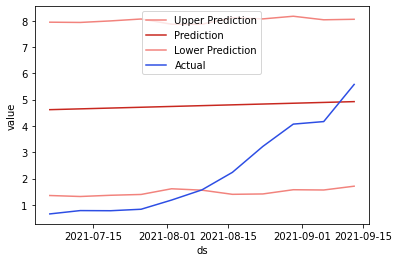

In [15]:
usa = forecastdf[forecastdf['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['yhat_upper', 'yhat', 'yhat_lower', 'actual'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa, palette=['#F2837D', '#C8271F', '#F2837D', '#2D4EE4'])
g.legend(title='', labels=['Upper Prediction', 'Prediction', 'Lower Prediction', 'Actual'])
plt.show(g)

In [16]:
from sklearn.metrics import mean_absolute_error
y_true = forecastdf['actual']
y_pred = forecastdf['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 2.181


In [17]:
## attempt with regressors
## forecast deaths by country
forecastdf2 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.add_regressor('stringency')
  m.add_regressor('vaccinations')
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf2 = pd.concat((forecastdf2, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

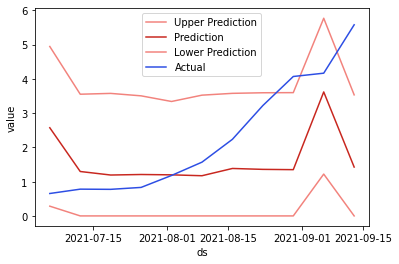

In [18]:
usa = forecastdf2[forecastdf2['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['yhat_upper', 'yhat', 'yhat_lower', 'actual'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa, palette=['#F2837D', '#C8271F', '#F2837D', '#2D4EE4'])
g.legend(title='', labels=['Upper Prediction', 'Prediction', 'Lower Prediction', 'Actual'])
plt.show(g)

In [19]:
y_true = forecastdf2['actual']
y_pred = forecastdf2['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 2.007


In [20]:
## attempt with just vaccinations
## forecast deaths by country
forecastdf3 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.add_regressor('vaccinations')
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf3 = pd.concat((forecastdf3, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

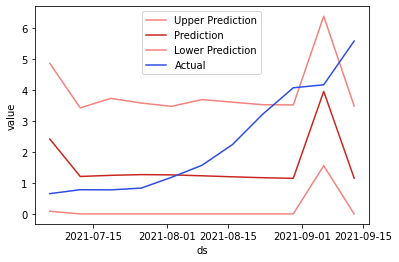

In [21]:
usa = forecastdf3[forecastdf3['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['yhat_upper', 'yhat', 'yhat_lower', 'actual'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa, palette=['#F2837D', '#C8271F', '#F2837D', '#2D4EE4'])
g.legend(title='', labels=['Upper Prediction', 'Prediction', 'Lower Prediction', 'Actual'])
plt.show(g)

In [22]:
y_true = forecastdf3['actual']
y_pred = forecastdf3['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 2.079


In [23]:
## attempt with just stringency
## forecast deaths by country
forecastdf4 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.add_regressor('stringency')
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf4 = pd.concat((forecastdf4, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

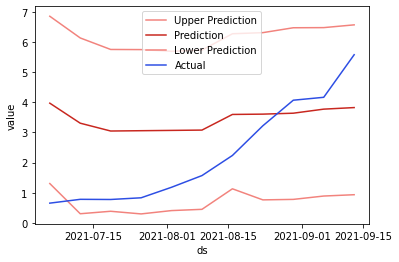

In [24]:
usa = forecastdf4[forecastdf4['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['yhat_upper', 'yhat', 'yhat_lower', 'actual'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa, palette=['#F2837D', '#C8271F', '#F2837D', '#2D4EE4'])
g.legend(title='', labels=['Upper Prediction', 'Prediction', 'Lower Prediction', 'Actual'])
plt.show(g)

In [25]:
y_true = forecastdf4['actual']
y_pred = forecastdf4['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 1.777


In [26]:
data.columns = ['CountryName', 'ds', 'stringency', 'vaccinations', 'death', 'y', 'lagds']
train = data[data['ds'] < '2021-07-01']
test = data[data['ds'] >= '2021-07-01']

In [27]:
## lagged deaths no regressors
forecastdf5 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf5 = pd.concat((forecastdf5, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

In [28]:
## lagged deaths with regressors
forecastdf6 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.add_regressor('stringency')
  m.add_regressor('vaccinations')
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf6 = pd.concat((forecastdf6, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

In [29]:
## lagged deaths just vaccinations
forecastdf7 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.add_regressor('vaccinations')
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf7 = pd.concat((forecastdf7, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

In [30]:
## lagged deaths just stringency
forecastdf8 = pd.DataFrame()

for x in tqdm(countries):
  temp_train = train[train.CountryName == x]
  temp_test = test[test.CountryName == x]
  m = Prophet(weekly_seasonality=False,
              daily_seasonality=True,
              yearly_seasonality=False)
  m.add_regressor('stringency')
  m.fit(temp_train)
  forecast = m.predict(temp_test)
  forecast['yhat'] = forecast['yhat'].clip(lower = 0)
  forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower = 0)
  forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower = 0)
  forecast['CountryName'] = x
  forecast['actual'] = temp_test['y'].reset_index(drop=True)
  forecastdf8 = pd.concat((forecastdf8, forecast));

  0%|          | 0/182 [00:00<?, ?it/s]

In [31]:
y_true = forecastdf5['actual']
y_pred = forecastdf5['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 2.209


In [32]:
y_true = forecastdf6['actual']
y_pred = forecastdf6['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 2.091


In [33]:
y_true = forecastdf7['actual']
y_pred = forecastdf7['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 2.155


In [34]:
y_true = forecastdf8['actual']
y_pred = forecastdf8['yhat']
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 1.982


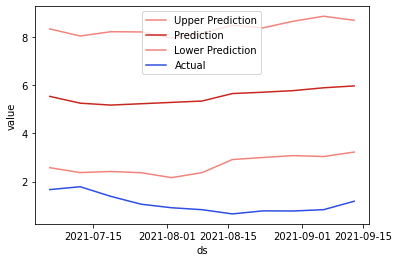

In [35]:
usa = forecastdf8[forecastdf8['CountryName'] == 'United States']
usa = usa.melt(id_vars=['ds', 'CountryName'], value_vars=['yhat_upper', 'yhat', 'yhat_lower', 'actual'])
g = sns.lineplot(x='ds', y='value', hue='variable', data=usa, palette=['#F2837D', '#C8271F', '#F2837D', '#2D4EE4'])
g.legend(title='', labels=['Upper Prediction', 'Prediction', 'Lower Prediction', 'Actual'])
plt.show(g)